In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import torchvision
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from IPython import display

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

data = torchvision.datasets.CIFAR10(root='./data/',transform=transform)
train_loader = DataLoader(data,batch_size=8,shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Learning image representations using compression.

Throughout this unit, we have pushed this idea that we need to find representations of images (or image patches or regions) that satisfy certain properties, are invariant to various conditions we may encounter, or generally useful for some downstream task. The supervised learning methods we have encountered specifically train the model to learn representations for the latter.

We now move to unsupervised approaches to representation learning. We'll start with an autoencoder. The idea is simple, we first squash our image into a latent vector, and then try to reconstruct the original image from this reduced representation. Remember how we used PCA for this before? We're going to do the same thing, but replace the linear projection with a non-linear function, parameterised by a neural network.

You will probably need a decent GPU to run the code below.



In [3]:
# Lets start by building an encoder model
class Encoder(nn.Module):
    
    def __init__(self,channels=3):
        super().__init__()
        
        self.encoder = nn.Sequential(nn.Conv2d(channels,32,kernel_size=4,stride=2,padding=1),
                                     nn.LeakyReLU(),
                                     nn.Conv2d(32,64,kernel_size=4,stride=2,padding=1),
                                     nn.LeakyReLU(),
                                     nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1),
                                     nn.LeakyReLU(),
                                     nn.Flatten())
        
    def forward(self,x):
        
        return self.encoder(x)
        
        

In [4]:
latent_dim = Encoder()(torch.randn(1,3,32,32)).shape[1]
print('Our encoder takes in a 32x32 dimensional image and outputs a feature vector of dimension:',latent_dim)

Our encoder takes in a 32x32 dimensional image and outputs a feature vector of dimension: 2048


In [5]:
# Next we will build a decoder model
class Decoder(nn.Module):
    
    def __init__(self,latent_dim=2048):
        super().__init__()
        
        
        self.decoder = nn.Sequential(nn.Unflatten(dim=-1,unflattened_size=(128,4,4)),
                                     nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1), #See https://d2l.ai/chapter_computer-vision/transposed-conv.html
                                     nn.LeakyReLU(),
                                     nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1),
                                     nn.LeakyReLU(),
                                     nn.ConvTranspose2d(32,3,kernel_size=4,stride=2,padding=1),
                                     nn.Sigmoid())
        
    def forward(self,x):
        
        return self.decoder(x)
        
        

In [6]:
print('Our decoder takes in %d dimensional latent and generates an image of dimension: %s'%(latent_dim,Decoder(latent_dim=latent_dim)(torch.randn(1,latent_dim)).shape))

Our decoder takes in 2048 dimensional latent and generates an image of dimension: torch.Size([1, 3, 32, 32])


### Activity:

The convolution parameters were carefully chosen to make these dimensions add up. Striding is used to both shrink and expand images. Try to change the architecture to take in 64x64 dim images and generate 64x64 images. Think about the convolution response size equations we looked at earlier in the unit - how could you avoid doing this by trial and error?

In [7]:
encoder = Encoder().to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)

#### Let's train our auto-encoder

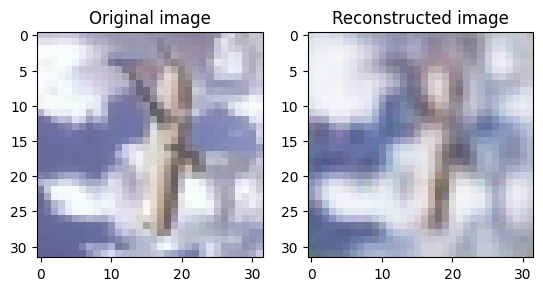

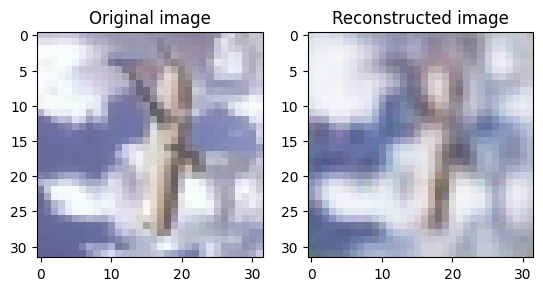

In [8]:
avg_loss = None  # exponential moving average
n_epochs = 2

optim = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),lr=1e-4)

# with tqdm.tqdm(total=n_epochs) as pbar:
    
for step in range(n_epochs):

    t = tqdm(total=len(train_loader))

    for i,batch in enumerate(train_loader):
        im,_ = batch
        im = im.to(device)
        
        optim.zero_grad()
        latent = encoder(im)
        im_recon = decoder(latent)
        loss = torch.sum(0.5*(im_recon-im)**2)/im.shape[0]
        
        loss.backward()
        optim.step()

        # Some visualisation during training.
        t.update(1)
        
        if avg_loss is None:
            avg_loss = loss.item()
        else:
            avg_loss = 0.95*avg_loss + 0.05*loss.item()
        t.set_description(f"Iter: {step}. Average Loss: {avg_loss:.04f}")
    t.reset()
        
    plt.clf()
    plt.subplot(1,2,1)
    plt.imshow(im[0,:,:,:].transpose(0,2).cpu())
    plt.title('Original image')
    plt.subplot(1,2,2)
    plt.imshow(im_recon[0,:,:,:].transpose(0,2).detach().cpu())
    plt.title('Reconstructed image')
    display.clear_output(wait=True)
    display.display(plt.gcf())

Cool, the autoencoder learns to compress our images and then reconstruct the original images. We could use these representations as features to match images, or train a classifier using the features directly.

Lets use a technique called [t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) to reduce the dimensionality of these latent features even further, and see whether the representations captured by our model learned anything interesting.

In [9]:
# Use encoder to extract feature vectors for all images
feats = []
labs = []
for i,batch in enumerate(train_loader):
    im,l = batch
    latent = encoder(im.to(device)) #to save time, I'll only take the first sample in each batch
    labs.append(l[0])
    feats.append(latent[0,:])
    
labs = torch.stack(labs).numpy()
feats = torch.vstack(feats).detach().cpu().numpy()
    

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6250 samples in 0.001s...
[t-SNE] Computed neighbors for 6250 samples in 0.746s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6250
[t-SNE] Computed conditional probabilities for sample 2000 / 6250
[t-SNE] Computed conditional probabilities for sample 3000 / 6250
[t-SNE] Computed conditional probabilities for sample 4000 / 6250
[t-SNE] Computed conditional probabilities for sample 5000 / 6250
[t-SNE] Computed conditional probabilities for sample 6000 / 6250
[t-SNE] Computed conditional probabilities for sample 6250 / 6250
[t-SNE] Mean sigma: 5.350546
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.724960
[t-SNE] KL divergence after 1000 iterations: 2.646334


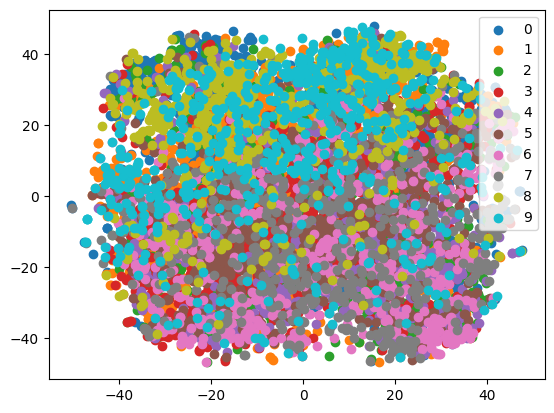

In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

feature = PCA(n_components=50).fit_transform(feats)
tsne_feat = TSNE(n_components=2,verbose=1).fit_transform(feature)

for i in range(10):
    plt.scatter(tsne_feat[labs == i, 0], tsne_feat[labs == i, 1])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], loc='upper right')
plt.show()

Hmm, I don't see a pattern in there.

## Variational Autoencoding

The autoencoder learns a deterministic transform for a single image. Let's extend it to make it a probabalistic generative model, using [variational autoencoding (VAE)](https://arxiv.org/abs/1312.6114). We've already encountered one of these before with our Gaussian mixture model
$$p(x) = \sum_{i=0}^N p(i) p(x|i)$$
$$p(x) = \sum_{i=0}^N \pi_i \mathcal{N}(x|\mu_i,\sigma_i)$$

Here, we could consider the Gaussian indicator a latent variable, and the Gaussian a conditional dependent on the value of i. We can formulate a more general version of this - a *latent variable model* of our image $I$, conditioned on a latent variable or feature vector $x$.

$$ p(I) = \int p(I|x)p(x) dx $$

If we want to fit this model to the space of images, we need some way to learn the distribution over images. *Variational* autoencoding provides us with an approach to do this. 

$$ p(I) = \int p(I|x) p(x) dx $$
Here, $p(I|x)$ is our decoder.

$$ \log p(I) = \log \int p(I|x) p(x) dz $$

Lets introduce an encoder model $q(I|x)$ into this equation:
$$ \log p(I) = \log \int q(x|I) \frac{p(I|x) p(x)}{q(x|I)} dx $$


$$ \log p(I) \ge \int q(x|I) \log \frac{p(I|x) p(x)}{q(x|I)} dx \,\,\,\,\,\,\,\,\,\,\,\, \text{See [Jensen] for this inequality} $$

$$ = \int q(x|I) \log p(I|x) dz  - \int q(x|I) \log \frac{q(x|I)}{p(x)} dx$$
$$ = \mathbb{E}_q [\log p(I|x)]  - \mathcal{KL}(q(x|I)||p(x))$$

We call this the evidence lower bound. This objective is cool, the first term is effectively a reconstruction quality term like we had in our original autoencoder. The second term is a divergence measure that pulls the distribution over the latent space to look like the prior $p(x)$ How do we choose the prior? Let's assume its a zero mean Gaussian $\mathcal{N}(0,1)$. Likewise, we will choose our $q(x|I)$ to be a Gaussian, using neural networks to predict the mean and variance of this. We sometimes call this a mean field approximation.  We often include a $\beta$ scaling parameter to better balance these losses - leading to [$\beta$-VAE](https://openreview.net/forum?id=Sy2fzU9gl).


In [11]:
class VAE(nn.Module):
    
    def __init__(self,latent_dim=128,device='cpu'):
        super().__init__()
        
        self.encoder = Encoder() 
        self.decoder = Decoder(latent_dim=latent_dim)
        
        # These layers project our encoded embedding to form the q(x|I) = N(mu,lsig)
        self.mu = nn.Linear(latent_dim,latent_dim)
        self.log_var = nn.Linear(latent_dim,latent_dim) # We use the log var to avoid numerical issues
        
        
        self.latent_dim = latent_dim
        self.device = device
        
        
    def reparametrise(self,mu,lvar): # This reparametrisation trick draws a sample from a Gaussian (remember week 7?)
        
        return mu + lvar.mul(0.5).exp()*torch.randn_like(mu).to(self.device) 
        
    def forward(self,x):
        
        z = self.encoder(x) 
        mu = self.mu(z)
        lvar = self.log_var(z)
        
        zs = self.reparametrise(mu,lvar) # Draw a sample
        
        x_recon = self.decoder(zs) # Reconstruct
        
        return x_recon, mu, lvar, zs
    
    def sample(self,Nsamples=1):
        
        z = torch.randn(Nsamples,self.latent_dim).to(self.device)
        return self.decoder(z)
    
    
    def loss_fn(self,x,beta=1e-2): #Copmpute full loss
        
        x_recon, mu, lvar, _ = self.forward(x)
        
        # Note the sign here, we are minimising this loss, so reducing the recon error and the divergence between q and p
        return torch.sum((x_recon-x)**2)/x.shape[0], -beta*0.5*torch.sum(1 + lvar - mu**2 -  lvar.exp())/x.shape[0]

In [12]:
model = VAE(device=device,latent_dim=latent_dim).to(device)

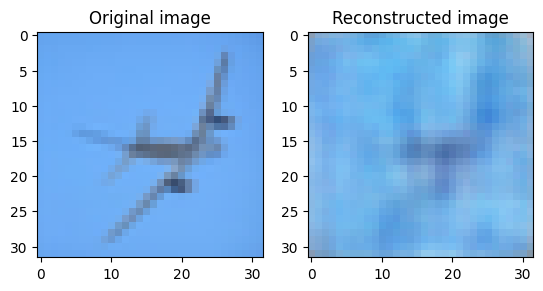

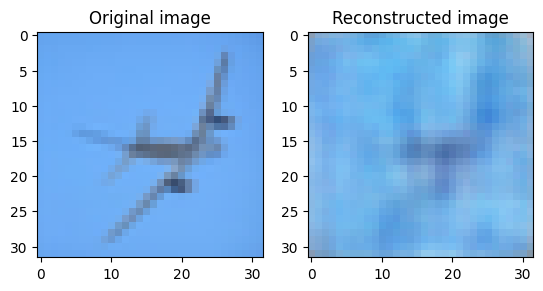

In [13]:
avg_recon_loss = None  # exponential moving average
avg_kl_loss = None  # exponential moving average
n_epochs = 5

optim = torch.optim.Adam(model.parameters(),lr=1e-4)

# with tqdm.tqdm(total=n_epochs) as pbar:
    
for step in range(n_epochs):

    t = tqdm(total=len(train_loader))

    for i,batch in enumerate(train_loader):
        im,_ = batch
        
        im = im.to(device)
        optim.zero_grad()
        recon_loss,kl_loss = model.loss_fn(im,beta=0.1)
        loss = recon_loss+kl_loss
         # I am training with a relatively high learning rate so I can show this in class, this clips my gradients so they don't explode
        # torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
        
        loss.backward()
        optim.step()

        # Some visualisation during training.
        t.update(1)
        
        if avg_recon_loss is None:
            avg_recon_loss = recon_loss.item()
        else:
            avg_recon_loss = 0.95*avg_recon_loss + 0.05*recon_loss.item()
            
        if avg_kl_loss is None:
            avg_kl_loss = kl_loss.item()
        else:
            avg_kl_loss = 0.95*avg_kl_loss + 0.05*kl_loss.item()
        t.set_description(f"Iter: {step}. Average Recon Loss: {avg_recon_loss:.04f} Average KL Loss: {avg_kl_loss:.04f}")
    t.reset()
    
    im_recon,_,_,_ = model(im)
        
    plt.clf()
    plt.subplot(1,2,1)
    plt.imshow(im[0,:,:,:].transpose(0,2).cpu())
    plt.title('Original image')
    plt.subplot(1,2,2)
    plt.imshow(im_recon[0,:,:,:].transpose(0,2).detach().cpu())
    plt.title('Reconstructed image')
    display.clear_output(wait=True)
    display.display(plt.gcf())

Let's see what happened to the latent space of our VAE. We trained with a very small KL term, did it do anything?

In [14]:
# Use encoder to extract feature vectors for all images
feats = []
labs = []
for i,batch in enumerate(train_loader):
    im,l = batch
    _,_,_,latent = model(im.to(device)) #to save time, I'll only take the first sample in each batch
    labs.append(l[0])
    feats.append(latent[0,:])
    
labs = torch.stack(labs).numpy()
feats = torch.vstack(feats).detach().cpu().numpy()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6250 samples in 0.001s...
[t-SNE] Computed neighbors for 6250 samples in 0.169s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6250
[t-SNE] Computed conditional probabilities for sample 2000 / 6250
[t-SNE] Computed conditional probabilities for sample 3000 / 6250
[t-SNE] Computed conditional probabilities for sample 4000 / 6250
[t-SNE] Computed conditional probabilities for sample 5000 / 6250
[t-SNE] Computed conditional probabilities for sample 6000 / 6250
[t-SNE] Computed conditional probabilities for sample 6250 / 6250
[t-SNE] Mean sigma: 3.103368
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.908119
[t-SNE] KL divergence after 1000 iterations: 3.870669


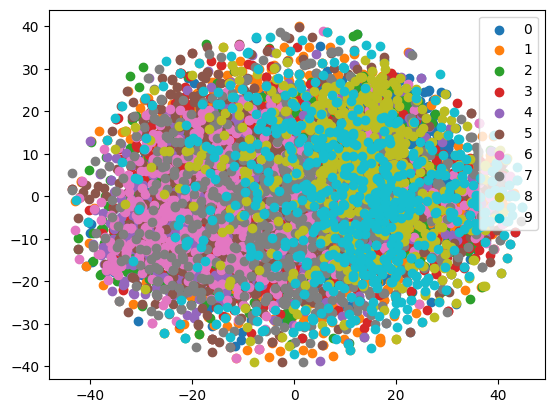

In [15]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

feature = PCA(n_components=50).fit_transform(feats)
tsne_feat = TSNE(n_components=2,verbose=1).fit_transform(feature)

for i in range(10):
    plt.scatter(tsne_feat[labs == i, 0], tsne_feat[labs == i, 1])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], loc='upper right')
plt.show()

The space is now much more structured. Even though TSNE is a projection of our high dimensional feature vector, everything lies in a nice compact space. Play around with the beta term in the VAE and see what effect it has on image quality/ latent space. You may also wanting to try adjusting the latent space dimension and seeing how this changes the latet space - do you see any clustering of similar class images?

Ok, that was a lot of maths. What did we gain? Well, first of all we got a generative model for free! Since we know that our images are squashed into a space that should look Gaussian, we can draw a sample from this distribution to decode. Lets look at some random samples.

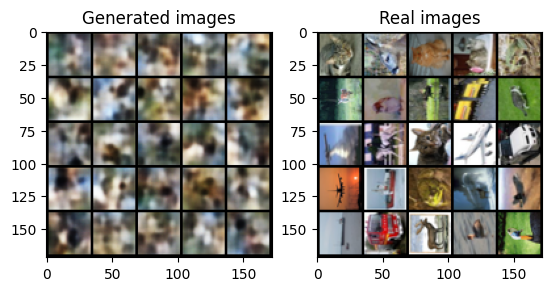

In [16]:
Ims = model.sample(Nsamples=25).detach().cpu()
grid_im = torchvision.utils.make_grid(Ims, nrow=5).transpose(0,2)
plt.subplot(1,2,1)
plt.imshow(grid_im)
plt.title('Generated images')
train_loader = DataLoader(data,batch_size=25,shuffle=True)
ims,_ = next(iter(train_loader))
grid_im = torchvision.utils.make_grid(ims, nrow=5).transpose(0,2)
plt.subplot(1,2,2)
plt.imshow(grid_im)
plt.title('Real images')
plt.show()

Nice. These look like they could be synthetic images. With the right architecture and some loss tweaks, this is a very powerful generative modelling technique. We rely on this heavily in my (Michael) own research on latent dynamics models for robotics. 

Unfortunately, these images still look quite blurry and don't really resemble anything usedul. Until recently, these kind of probabilistic generative models had fallen out of favour, with generative adversarial networks producing much higher quality images. As we'll see in another notebook, diffusion models have thankfully made probabilistic generative models great again.